In [1]:
from matplotlib import pyplot as plt
import numpy as np
import torch

from zsl_utils.olmo import get_olmo_model_steps
from zsl_config import ZSL_DIR_ANALYSIS
from zsl_utils.grad_analysis.reduce import init_metrics
from zsl_utils.mpl import *

In [21]:
MODEL_CLASS = 'olmo'
DATASET = 'c4_en_val'
ANALYSIS_NAME = 'grad_intrf_token'
OUT_DIR = ZSL_DIR_ANALYSIS / f"{ANALYSIS_NAME}/{MODEL_CLASS}-{DATASET}"
assert OUT_DIR.exists()

FIG_DIR = Path.cwd() / "fig"
FIG_DIR.mkdir(exist_ok=True)

In [22]:
# keys in metrics
init_metrics(1,2)

{'C_i_gij_hist': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]),
 'Σj_Σi_gij': 0,
 'Σj_Σi_abs_gij': 0,
 'C_j_pij': tensor([[0., 0.]]),
 'Σj_pij': tensor([[0., 0.]]),
 'Σj_abs_pij': tensor([[0., 0.]]),
 'C_j_qj': 0,
 'Σj_qj': 0,
 'Σj_abs_qj': 0,
 'Cg': 0,
 'Σj_abs_Σi_pij': 0,
 'Σj_Σi_abs_pij': 0,
 'Cug': 0,
 'Σi_abs_Σj_pij': 0,
 'CuG': 0,
 'Σj_Σi_pij': 0,
 'C_i_dli': 0,
 'M_i_dli': 0,
 'norm_l2sq_delta': 0,
 'norm_l2sq_G': 0,
 'norm_l2sq_gi': tensor([[0., 0.]]),
 'norm_l1_delta': 0,
 'norm_l1_G': 0,
 'norm_l1_gi': tensor([[0., 0.]])}

In [23]:
RUNS = [
        '1028-rmsnorm-14m',
        '1028-rmsnorm-37m',
        '1028-rmsnorm-78m',
        '1028-rmsnorm-144m',
        # Not run because too long/expensive
        # '1028-rmsnorm-285m',
        # '1028-rmsnorm-472m',
    ]

def get_batch_dirs(run):
    out_dir = OUT_DIR / run
    batches = list(out_dir.glob("train-batch=*"))
    return batches

def load_metrics(batch_dir, metric_key, train_step):
    assert metric_key in [
        'train/losses_init',
        'train/losses_post',
        'train/grad',
        f'eval-{DATASET}/losses_init',
        f'eval-{DATASET}/losses_post',
        f'eval-{DATASET}/grad',
    ]

    f = batch_dir / f"{metric_key}/step{train_step}.pt"
    return torch.load(f, map_location='cpu')

run = RUNS[0]
split = 'train'
steps = get_olmo_model_steps(run)
batch_dir = get_batch_dirs(run)[0]
metrics = load_metrics(batch_dir, f'{split}/grad', steps[0])

/tmp/ipykernel_32494/82116996.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location='cpu')


/tmp/ipykernel_32494/82116996.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location='cpu')


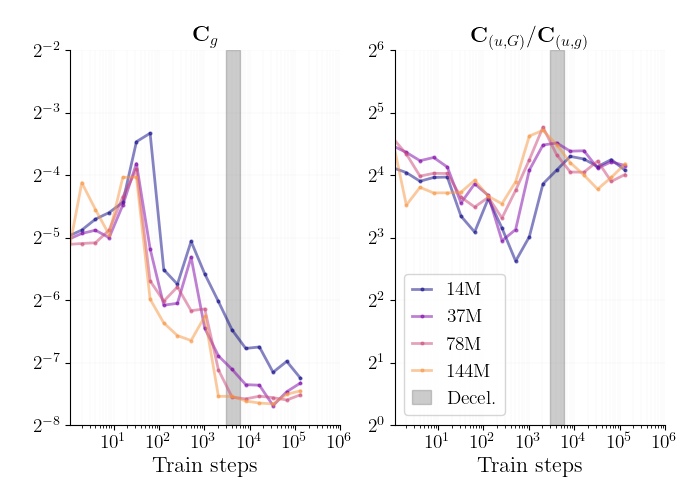

(<Figure size 700x500 with 2 Axes>,
 (<Axes: title={'center': '$\\mathbf{C}_{g}$'}, xlabel='Train steps'>,
  <Axes: title={'center': '$\\mathbf{C}_{(u,G)} / \\mathbf{C}_{(u,g)}$'}, xlabel='Train steps'>))

In [25]:
get_fp = lambda n: FIG_DIR / f'grad_intrf_true/{n}'

@torch.no_grad()
def plot_data(axs, run, label, split='train', seed_idx=0, non_embed=True):
    ax1,ax2 = axs
    steps = get_olmo_model_steps(run)
    # drop last step because of issue with learning rate
    steps = steps[:-1]
    batch_dir = get_batch_dirs(run)[seed_idx]
    color = get_color(RUNS.index(run), vmax=len(RUNS))
    
    cg = []
    cug_ratio = []
    c_dli = []

    for step in steps:
        metrics = load_metrics(batch_dir, f'{split}/grad', step)['model']
        cg += [metrics['Cg']]
        cug_ratio += [metrics['CuG'] / metrics['Cug']]
        c_dli += [cg[-1]*cug_ratio[-1]]

    ax1.plot(steps, cg, alpha=0.5, color=color, marker='o', linewidth=2, ms=2, label=label)
    ax2.plot(steps, cug_ratio, alpha=0.5, color=color, marker='o', linewidth=2, ms=2, label=label)
    return ax1, ax2

def format_and_save_plot(fig, axs, path=None):
    axs[0].set_title(
        '$\mathbf{C}_{g}$', 
    )
    axs[1].set_title(
        '$\mathbf{C}_{(u,G)} / \mathbf{C}_{(u,g)}$', 
    )

    for ax in axs:
        xlabel = 'Train steps'
        ax.set_xlabel(xlabel)
        ax.set_xscale('log')
        ax.set_xlim(1.1, 1e6)
        ax.xaxis.set_major_locator(mtick.LogLocator(numticks=999))
        ax.xaxis.set_minor_locator(mtick.LogLocator(numticks=999, subs="auto"))
        # HACK: make sure log scale ticks/grids are visible
        ax.set_yscale('log', base=2)        
    axs[0].set_ylim(2**(-8), 2**(-2))
    axs[1].set_ylim(2**(0), 2**(6))
    for ax in axs:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(linewidth=0.1, alpha=0.8, color='gray', linestyle='dotted', which='both')

    for ax in axs:
        for p in ax.patches:
            if p.get_label() == 'Decel.':
                p.remove()
        ax.axvspan(3000, 6000, color='gray', alpha=0.4, label='Decel.')
    
    ax = axs[-1]
    ax.legend(handlelength=1, fontsize=14,  loc='lower left')

    plt.close(fig)
    fig.set_size_inches(7,5)
    fig.subplots_adjust(left=0.1, right=0.95, top=0.9, bottom=0.15)
    if path:
        if not path.parent.exists():
            path.parent.mkdir(parents=True)
        fig.savefig(path, format="pdf")
        fig.savefig(path.with_suffix('.png'), format="png")
        display(PIL.Image.open(path.with_suffix('.png')))
    return fig, axs

fig, axs = plt.subplots(figsize=FIGSIZE_MED, nrows=1, ncols=2, sharey=False, sharex=True)
for i, run in enumerate(RUNS):
    model_size = run.split('-')[-1].replace('m', 'M')
    axs = plot_data(axs, run, model_size, split=f'eval-{DATASET}')

format_and_save_plot(fig, axs, get_fp('cucg.pdf'))


/tmp/ipykernel_32494/82116996.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location='cpu')


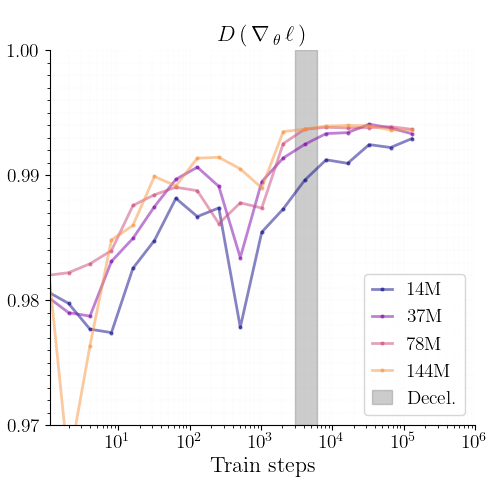

(<Figure size 500x500 with 1 Axes>,
 <Axes: title={'center': '$D\\,(\\,\\nabla_{\\:\\theta} \\, \\ell \\,)$'}, xlabel='Train steps'>)

In [26]:
@torch.no_grad()
def plot_data(ax, run, label, split='train', seed_idx=0, non_embed=True):
    steps = get_olmo_model_steps(run)
    # drop last step because of issue with learning rate
    steps = steps[:-1]
    batch_dir = get_batch_dirs(run)[seed_idx]
    color = get_color(RUNS.index(run), vmax=len(RUNS))
    
    gdis = [] # compute for each coordinate then average
    for step in steps:
        metrics = load_metrics(batch_dir, f'{split}/grad', step)['param']
        gdi = 0
        n = 0
        for param_name, param_metrics in metrics.items():
            if non_embed and param_name in ['transformer.wte.weight','transformer.ff_out.weight']:
                continue
            H = param_metrics['C_i_gij_hist']
            hist_bins = torch.linspace(0,1,101)
            for i, (b1,b2) in enumerate(zip(hist_bins[:-1], hist_bins[1:])):
                x = b1 + (b2 - b1)/2
                gdi += (1-x) * H[i]
                n += H[i]

        gdis += [gdi/n]

    ax.plot(steps, gdis, alpha=0.5, color=color, marker='o', linewidth=2, ms=2, label=label)
    return ax

def format_and_save_plot(fig, ax, path=None):
    ax.set_title(
        '$D\,(\,\\nabla_{\:\\theta} \, \ell \,)$', 
    )

    xlabel = 'Train steps'
    ax.set_xlabel(xlabel)
    ax.set_xscale('log')
    ax.set_xlim(1.1, 1e6)
    ax.xaxis.set_major_locator(mtick.LogLocator(numticks=999))
    ax.xaxis.set_minor_locator(mtick.LogLocator(numticks=999, subs="auto"))
    ax.set_ylim(0.97,1.0)
    ax.yaxis.set_major_locator(mtick.MultipleLocator(0.01))
    ax.yaxis.set_minor_locator(mtick.MultipleLocator(0.001))

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(linewidth=0.1, alpha=0.4, color='gray', linestyle='dotted', which='both')

    for p in ax.patches:
        if p.get_label() == 'Decel.':
            p.remove()
    ax.axvspan(3000, 6000, color='gray', alpha=0.4, label='Decel.')
    
    ax.legend(handlelength=1, fontsize=14,  loc='lower right')

    plt.close(fig)
    fig.set_size_inches(5,5)
    fig.subplots_adjust(left=0.1, right=0.95, top=0.9, bottom=0.15)
    if path:
        fig.savefig(path, format="pdf")
        fig.savefig(path.with_suffix('.png'), format="png")
        display(PIL.Image.open(path.with_suffix('.png')))
    return fig, ax


fig, ax = plt.subplots(figsize=(3,3))
for i, run in enumerate(RUNS):
    model_size = run.split('-')[-1].replace('m', 'M')
    ax = plot_data(ax, run, model_size, split=f'eval-{DATASET}')

format_and_save_plot(fig, ax, get_fp('grad_intrf_true.pdf'))


## Additional sanity check (true vs. pred change in loss)

/tmp/ipykernel_2876825/498909875.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location='cpu')
/tmp/ipykernel_2876825/498909875.py:26: Future

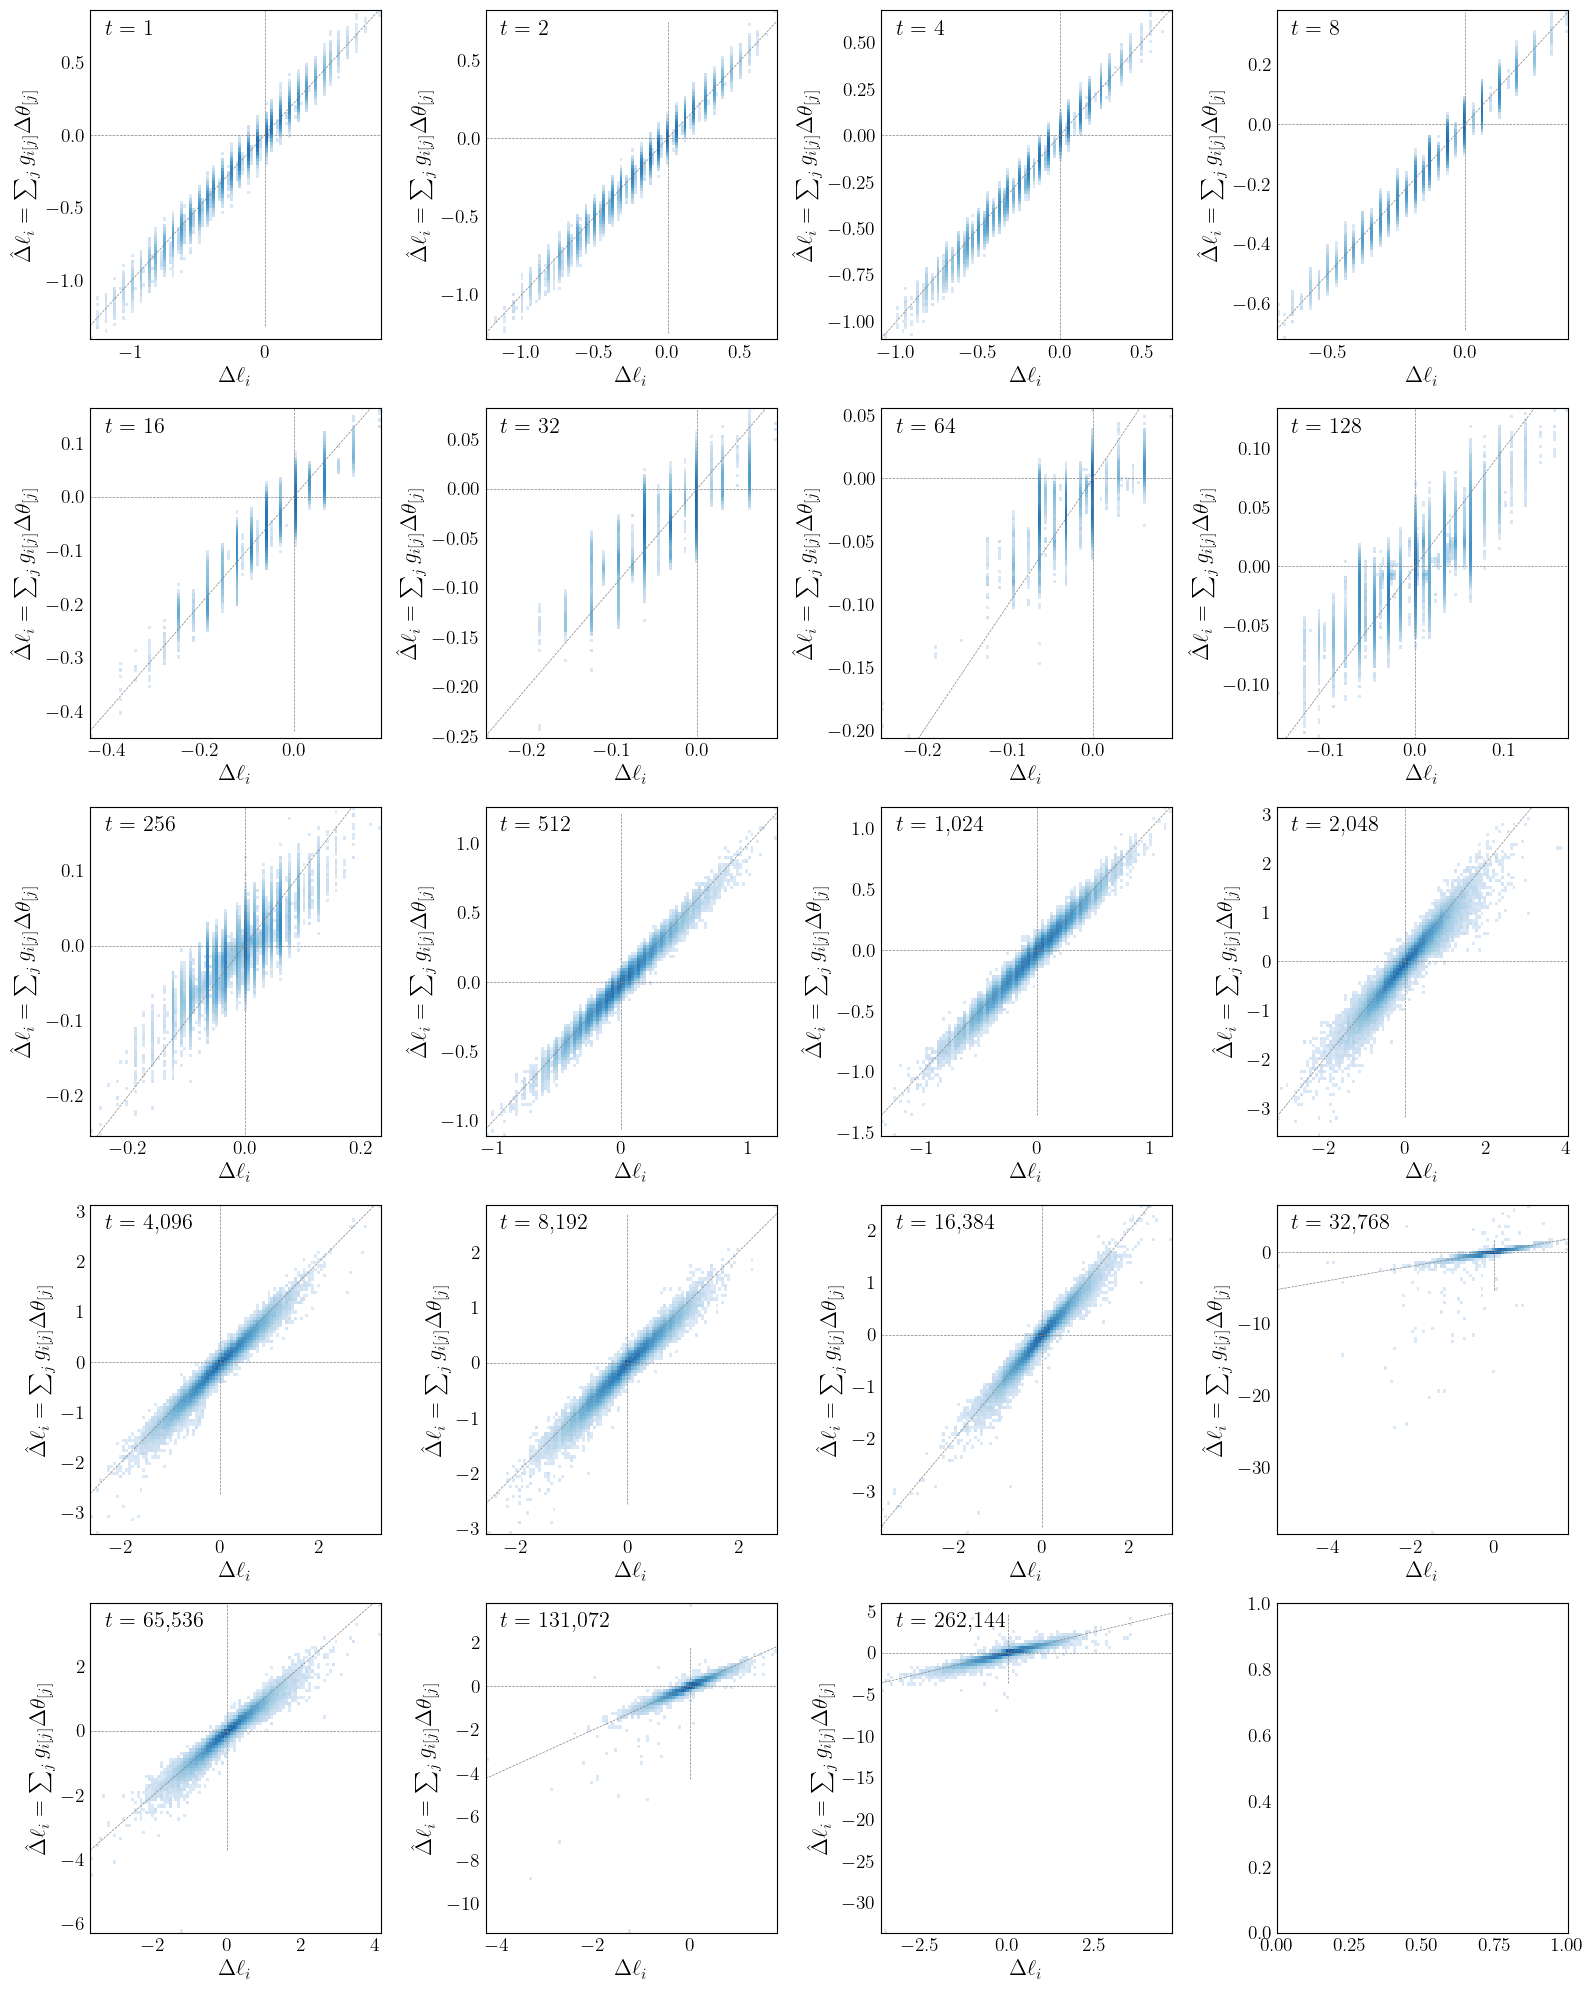

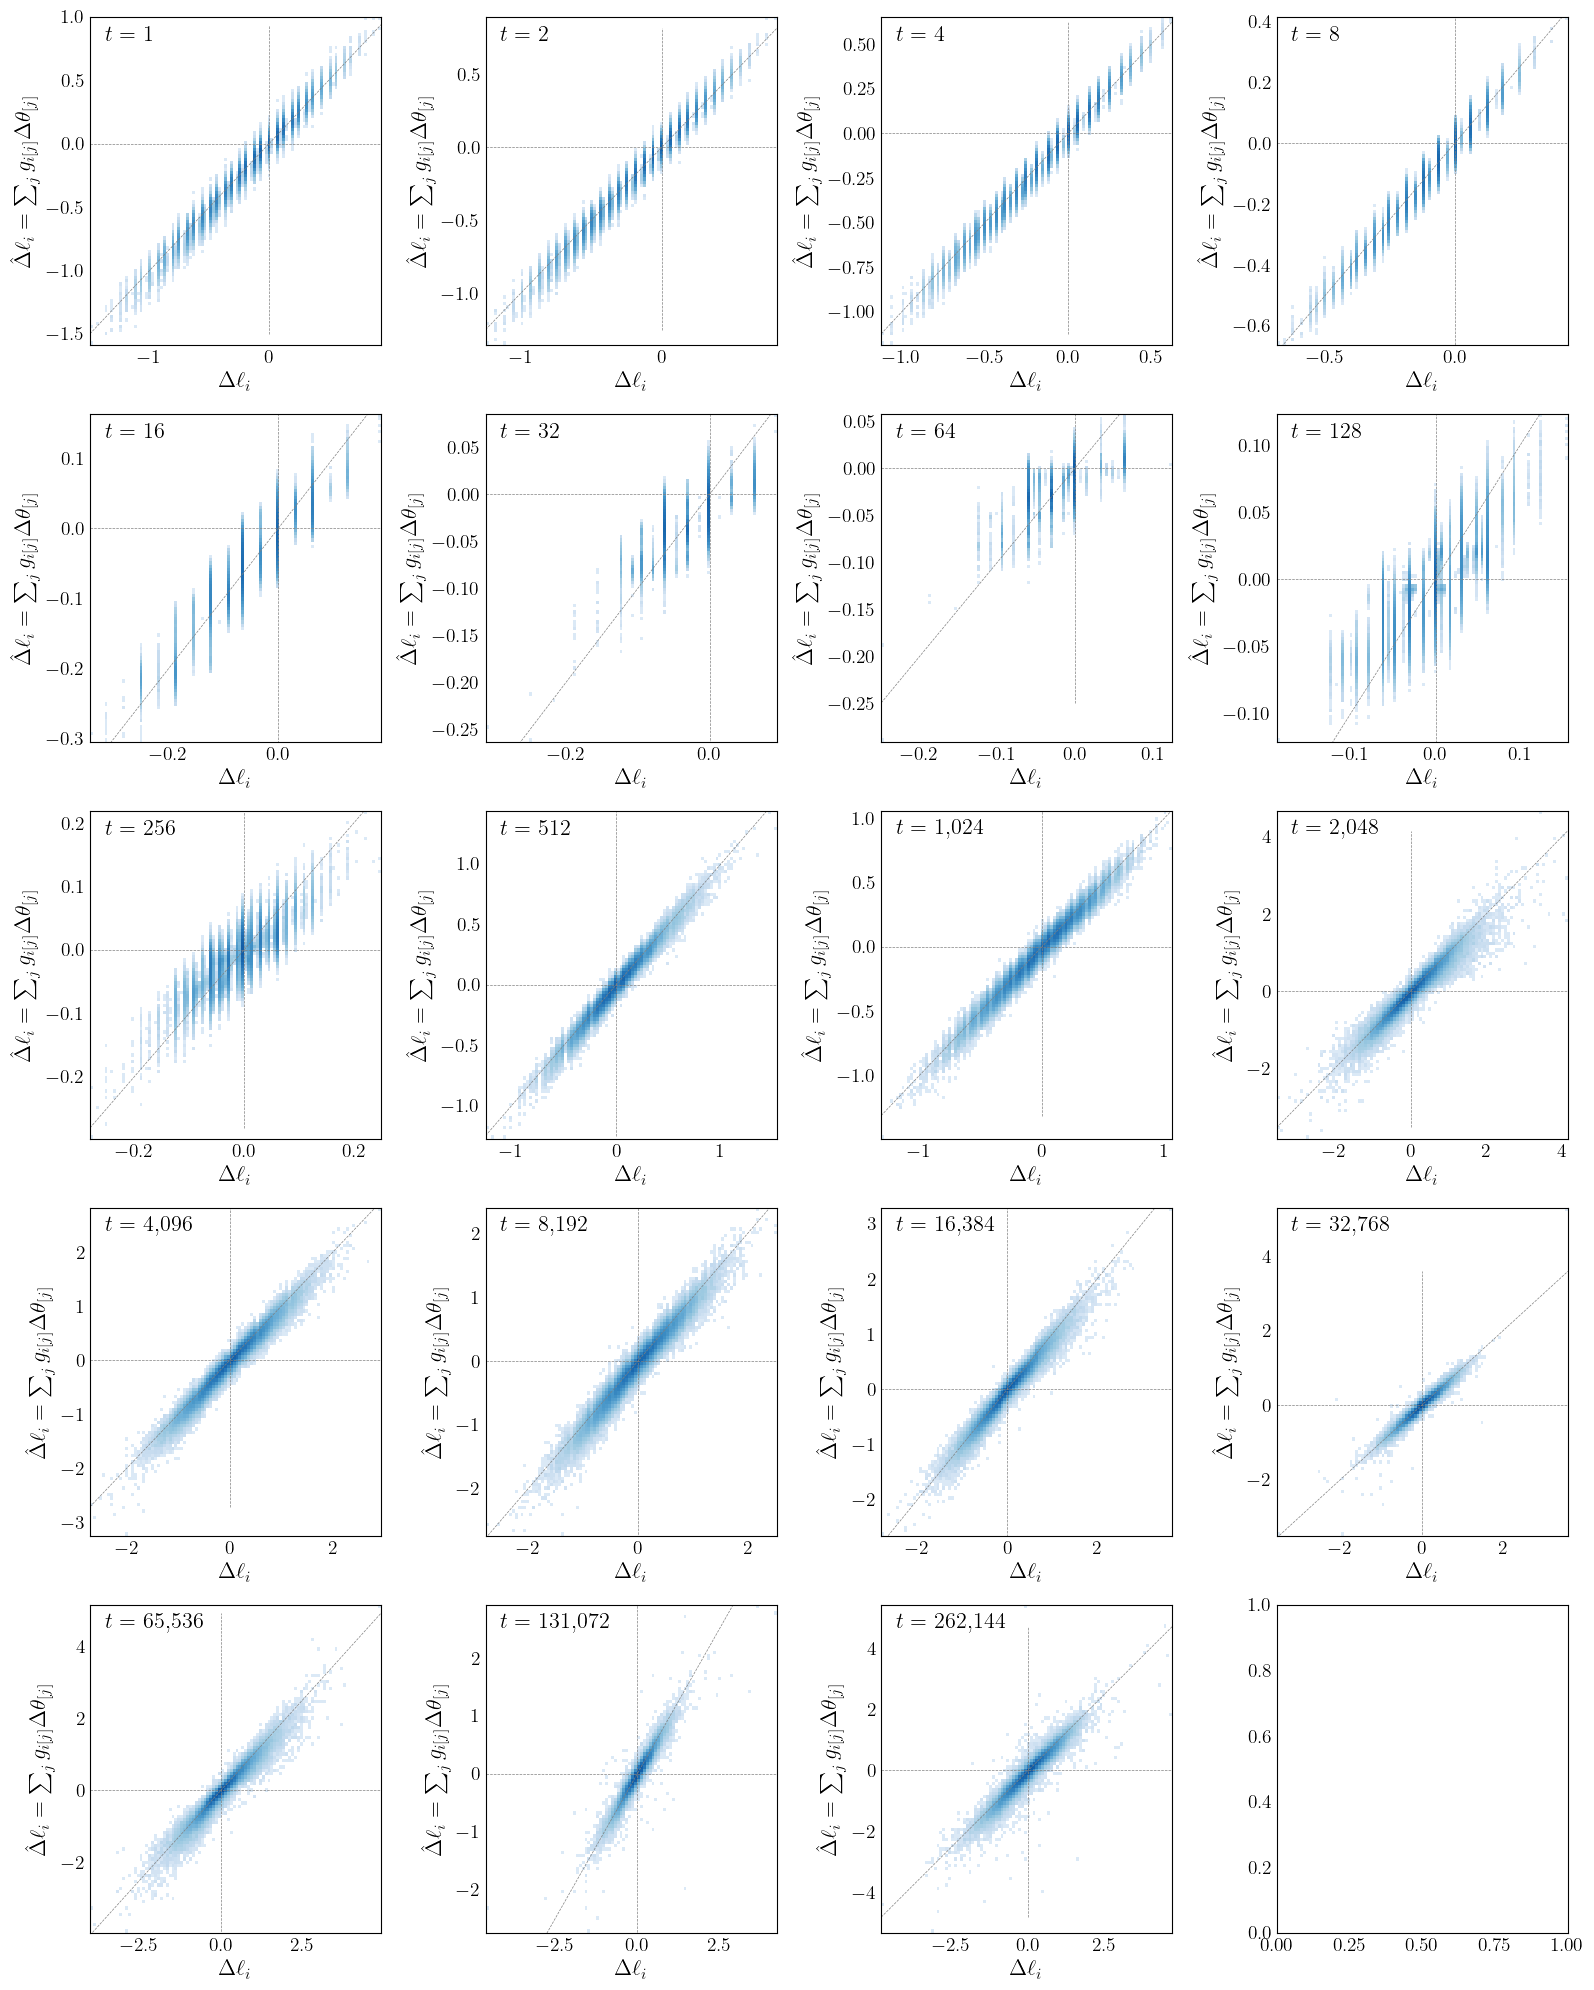

In [194]:
run = RUNS[0]
steps = [2**i for i in range(19)]
batch_dir = get_batch_dirs(run)[0]

ncols = 4
nrows = int(np.ceil(len(steps) / ncols))
plt.style.use('_mpl-gallery-nogrid')

for split in ['train', f'eval-{DATASET}']:
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=False, sharey=False, figsize=(4*ncols, 4*nrows))
    cnorm = mpl.colors.LogNorm(vmin=1e-1, vmax=1e6)
    # flatten axs
    axs = axs.flatten()
    for i, step in enumerate(steps):
        metrics = load_metrics(batch_dir, f'{split}/grad', step)['model']
        delta_losses_pred = metrics['Σj_pij'].flatten()

        losses_init = load_metrics(batch_dir, f'{split}/losses_init', step)
        losses_post = load_metrics(batch_dir, f'{split}/losses_post', step)
        delta_losses_true = (losses_post - losses_init).flatten()

        # delta_losses_pred.clamp_(min=-losses_init)

        ax = axs[i]
        h = ax.hist2d(
            delta_losses_true,
            delta_losses_pred,
            bins=100,
            norm=cnorm,
        )
        ax.set_xlabel('$\Delta \ell_i$')
        ax.set_ylabel('$\hat{\Delta} \ell_i = \sum_j g_{i[j]}  \Delta \\theta_{[j]}$')
        # if i % ncols == ncols - 1:
        #     fig.colorbar(h[3], ax=ax)

        # add diagonal line for y = x
        x1,x2 = delta_losses_true.min(), delta_losses_true.max()
        y1,y2 = delta_losses_true.min(), delta_losses_true.max()
        grid_kwargs = dict(color='gray', linestyle='--', linewidth=0.5, alpha=1)
        ax.plot([x1,x2],[y1,y2], **grid_kwargs)
        ax.plot([x1,x2],[0,0], **grid_kwargs)
        ax.plot([0,0],[y1,y2], **grid_kwargs)

        ax.set_title(f"$t=$ {step:,}", 
                     # set title location in terms of x,y coords, don't use loc
                        loc='left',
                        x=0.05, y=0.9,
                     )
    fig.tight_layout()
    fig.show()

    

/tmp/ipykernel_2876825/498909875.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location='cpu')


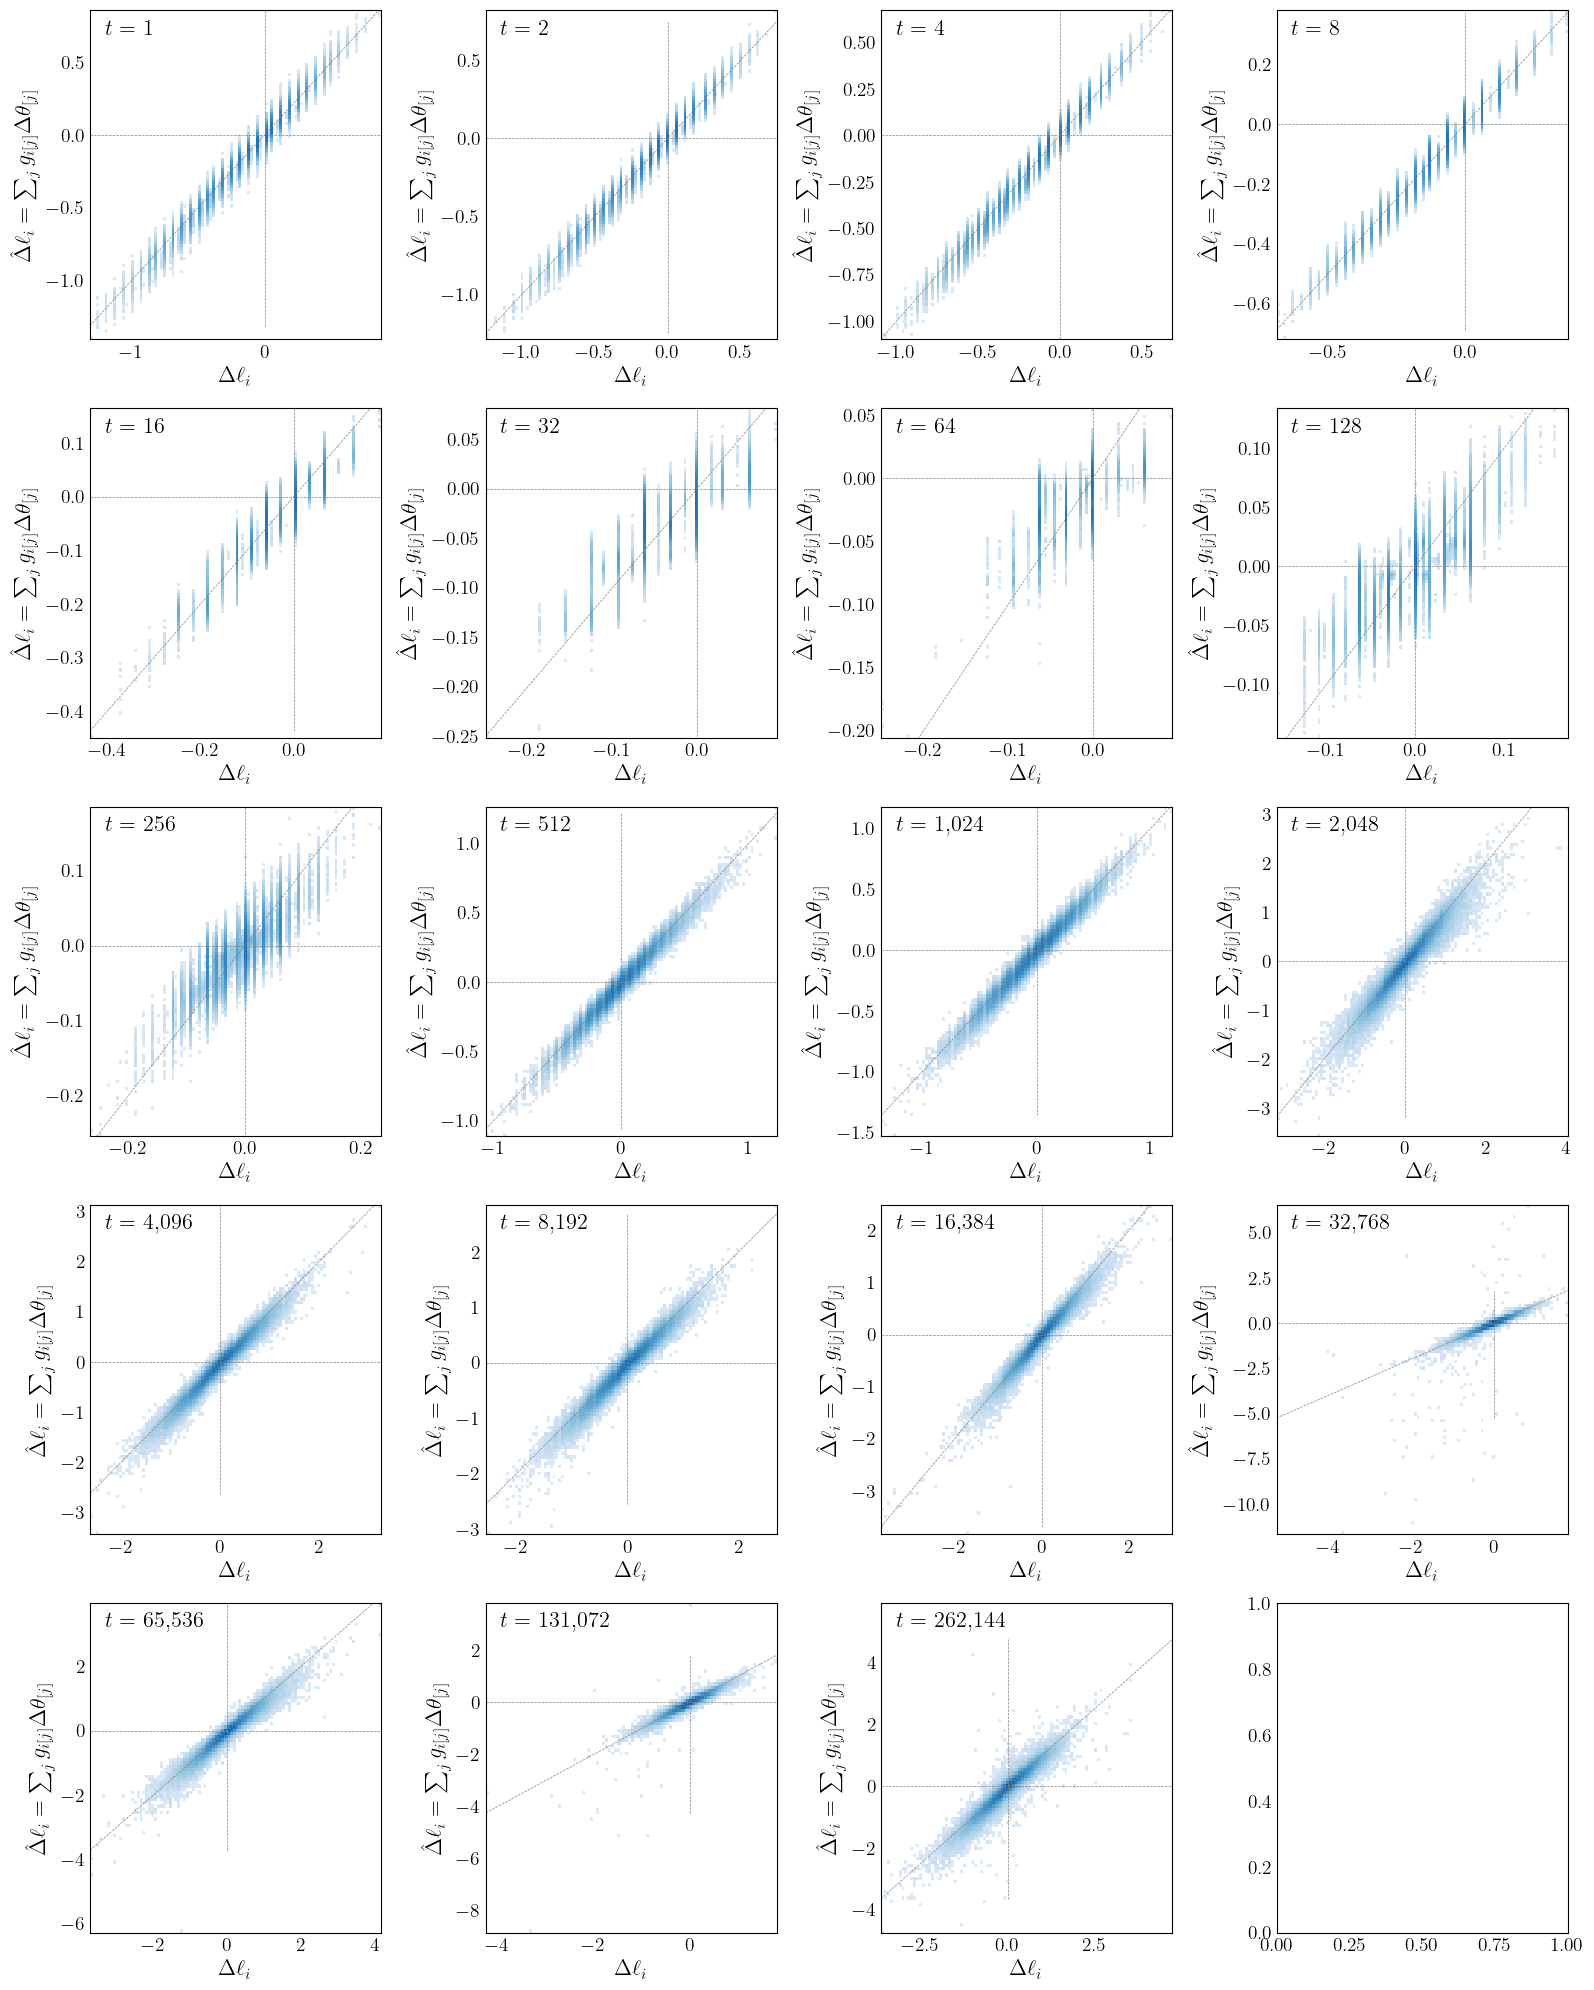

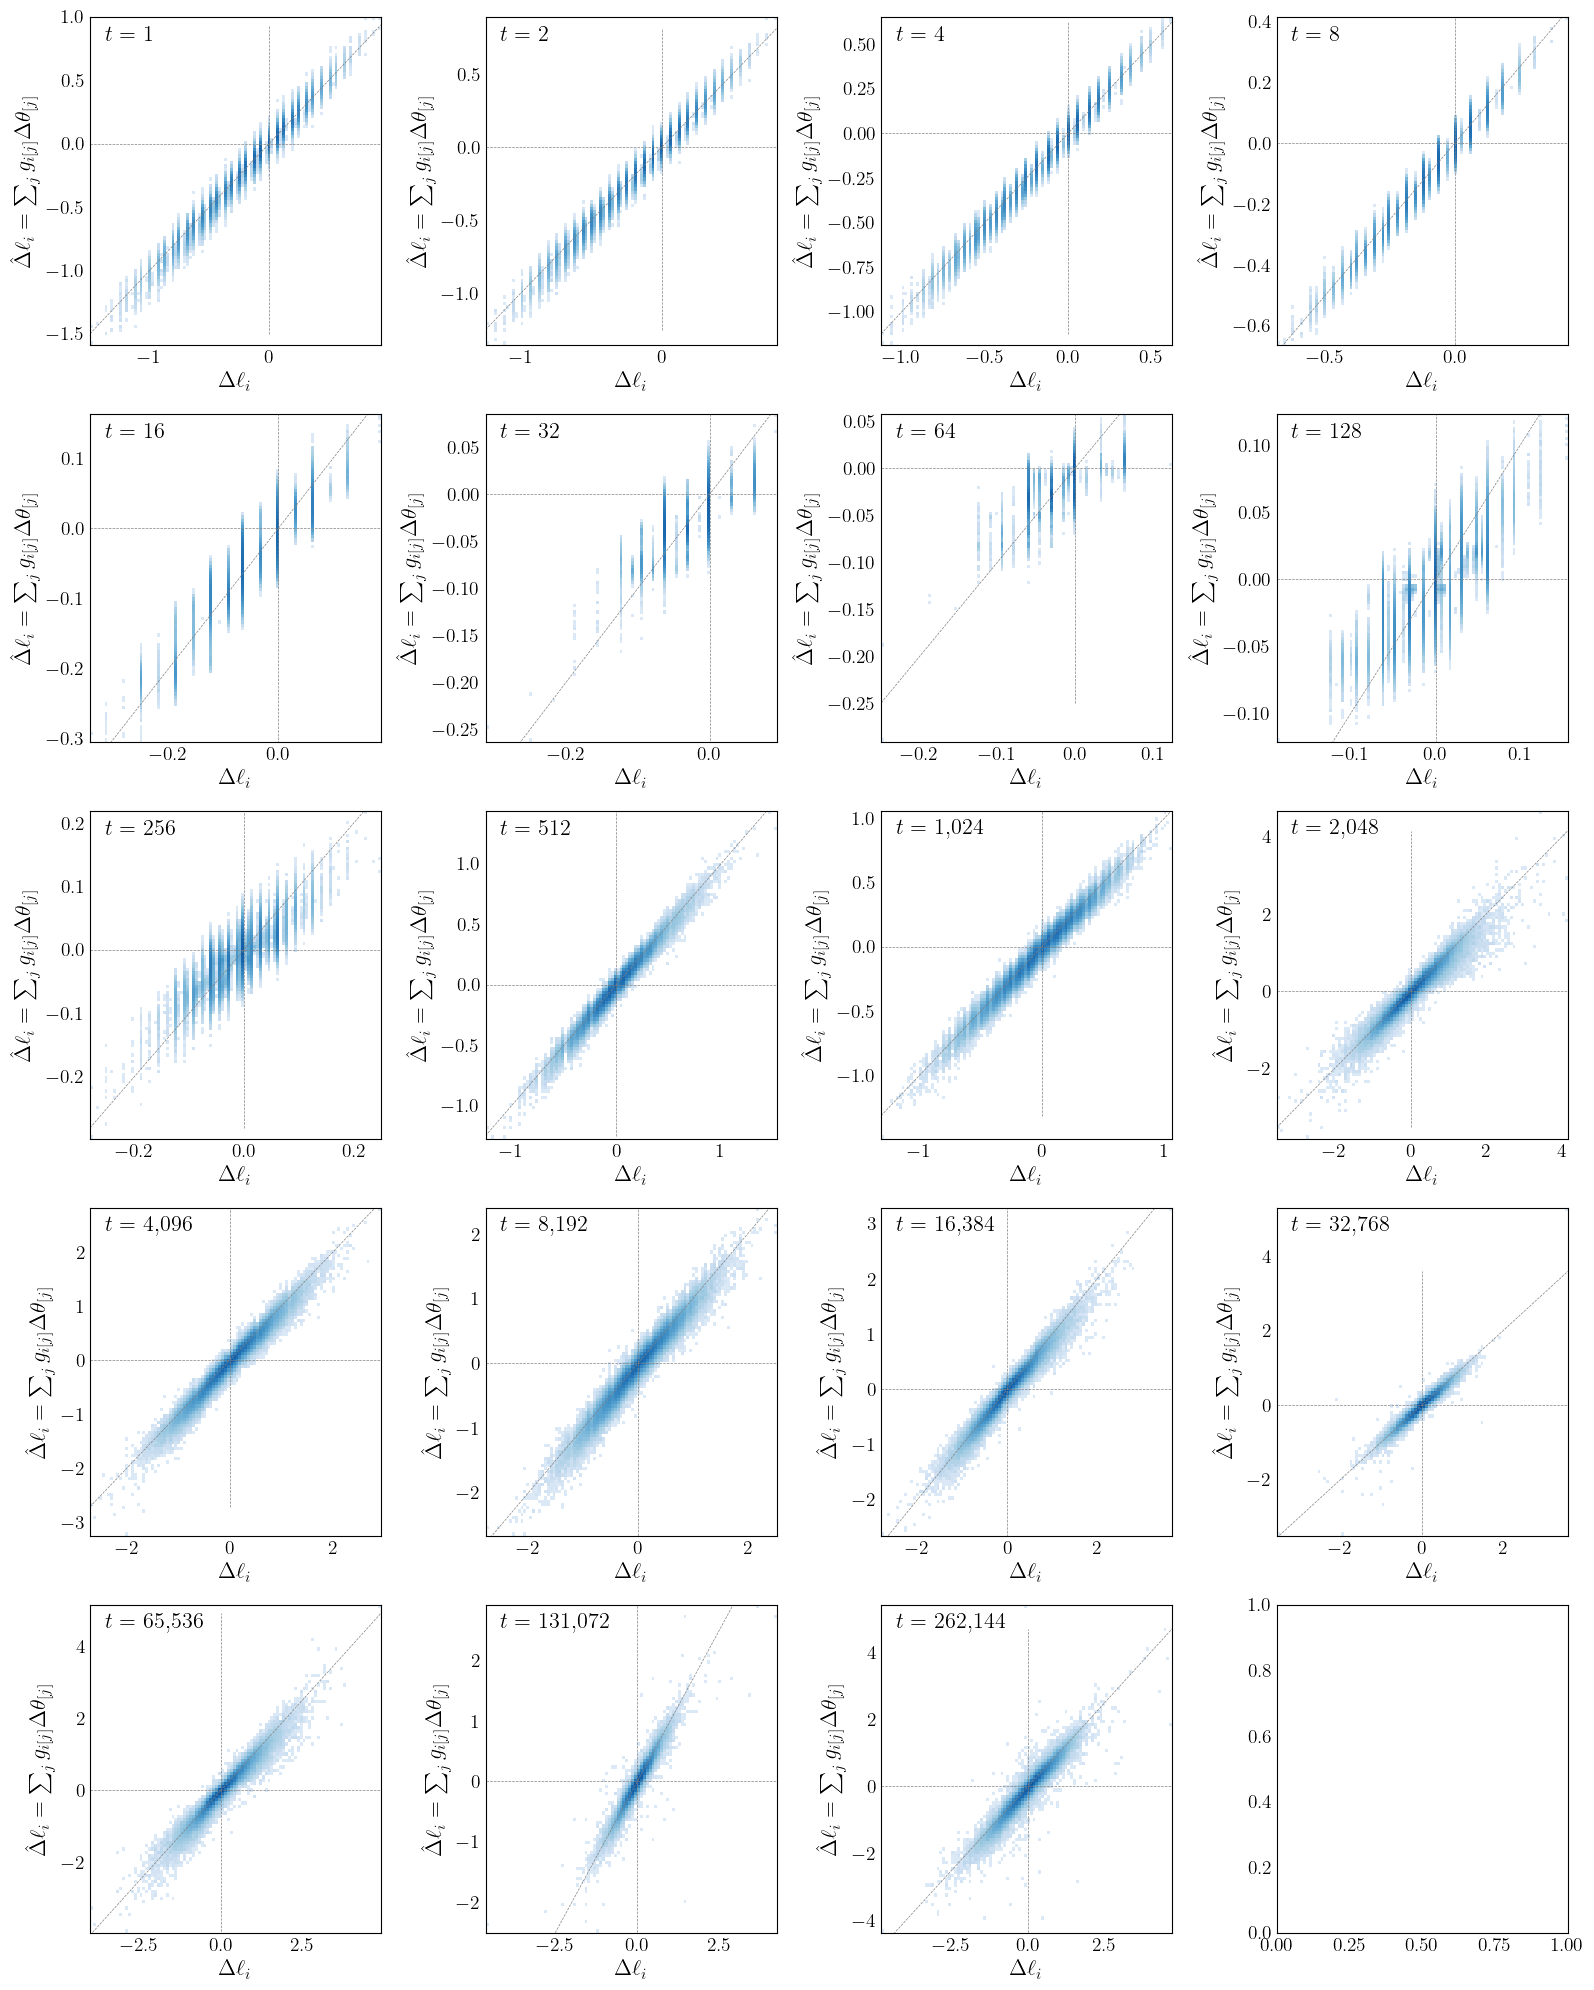

In [195]:
run = RUNS[0]
steps = [2**i for i in range(19)]
batch_dir = get_batch_dirs(run)[0]

ncols = 4
nrows = int(np.ceil(len(steps) / ncols))
plt.style.use('_mpl-gallery-nogrid')

for split in ['train', f'eval-{DATASET}']:
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=False, sharey=False, figsize=(4*ncols, 4*nrows))
    cnorm = mpl.colors.LogNorm(vmin=1e-1, vmax=1e6)
    # flatten axs
    axs = axs.flatten()
    for i, step in enumerate(steps):
        metrics = load_metrics(batch_dir, f'{split}/grad', step)['model']
        delta_losses_pred = metrics['Σj_pij'].flatten()

        losses_init = load_metrics(batch_dir, f'{split}/losses_init', step)
        losses_post = load_metrics(batch_dir, f'{split}/losses_post', step)
        delta_losses_true = (losses_post - losses_init).flatten()

        delta_losses_pred.clamp_(min=-losses_init)

        ax = axs[i]
        h = ax.hist2d(
            delta_losses_true,
            delta_losses_pred,
            bins=100,
            norm=cnorm,
        )
        ax.set_xlabel('$\Delta \ell_i$')
        ax.set_ylabel('$\hat{\Delta} \ell_i = \sum_j g_{i[j]}  \Delta \\theta_{[j]}$')
        # if i % ncols == ncols - 1:
        #     fig.colorbar(h[3], ax=ax)

        # add diagonal line for y = x
        x1,x2 = delta_losses_true.min(), delta_losses_true.max()
        y1,y2 = delta_losses_true.min(), delta_losses_true.max()
        grid_kwargs = dict(color='gray', linestyle='--', linewidth=0.5, alpha=1)
        ax.plot([x1,x2],[y1,y2], **grid_kwargs)
        ax.plot([x1,x2],[0,0], **grid_kwargs)
        ax.plot([0,0],[y1,y2], **grid_kwargs)

        ax.set_title(f"$t=$ {step:,}", 
                     # set title location in terms of x,y coords, don't use loc
                        loc='left',
                        x=0.05, y=0.9,
                     )
    fig.tight_layout()
    fig.show()

    